# Preparación de datos.
## Caracterización de variables

In [28]:
%load_ext autoreload
%autoreload 2

# Importamos librerías 
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import scipy.stats as stats

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Escalado de features
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Pipelinessss
from sklearn.pipeline import Pipeline

# Libraries to plot
import seaborn as sns

#Import the metrics class
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error


# Import to balance data
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Datasets.

In [2]:
DATASET_PATH="./data"
!ls {DATASET_PATH}

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
df = pd.read_csv(DATASET_PATH+"/PS_20174392719_1491204439457_log.csv")

In [4]:
#Exploring the features availables in the df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


### Statiscal information about variables

In [6]:
df.describe().round()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0,6362620.0
mean,243.0,179862.0,833883.0,855114.0,1100702.0,1224996.0,0.0,0.0
std,142.0,603858.0,2888243.0,2924049.0,3399180.0,3674129.0,0.0,0.0
min,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,156.0,13390.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,239.0,74872.0,14208.0,0.0,132706.0,214661.0,0.0,0.0
75%,335.0,208721.0,107315.0,144258.0,943037.0,1111909.0,0.0,0.0
max,743.0,92445517.0,59585040.0,49585040.0,356015889.0,356179279.0,1.0,1.0


In [7]:
print('El porcentaje de casos de fraude es % \n', (df['isFraud'].value_counts()[1]/len(df)*100).round(4))

print(round(df.amount[df.isFraud ==0].describe()),2)

El porcentaje de casos de fraude es % 
 0.1291
count     6354407.0
mean       178197.0
std        596237.0
min             0.0
25%         13368.0
50%         74685.0
75%        208365.0
max      92445517.0
Name: amount, dtype: float64 2


In [8]:
print('El porcentaje de casos de NO fraude es % \n', (df['isFraud'].value_counts()[0]/len(df)*100).round(4))

print(round(df.amount[df.isFraud ==1].describe()),2)

El porcentaje de casos de NO fraude es % 
 99.8709
count        8213.0
mean      1467967.0
std       2404253.0
min             0.0
25%        127091.0
50%        441423.0
75%       1517771.0
max      10000000.0
Name: amount, dtype: float64 2


## Preparación de datos

Funcion de utilería para mostrar distribuciones.

In [9]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=12, ylabelsize=12,figsize=(22,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

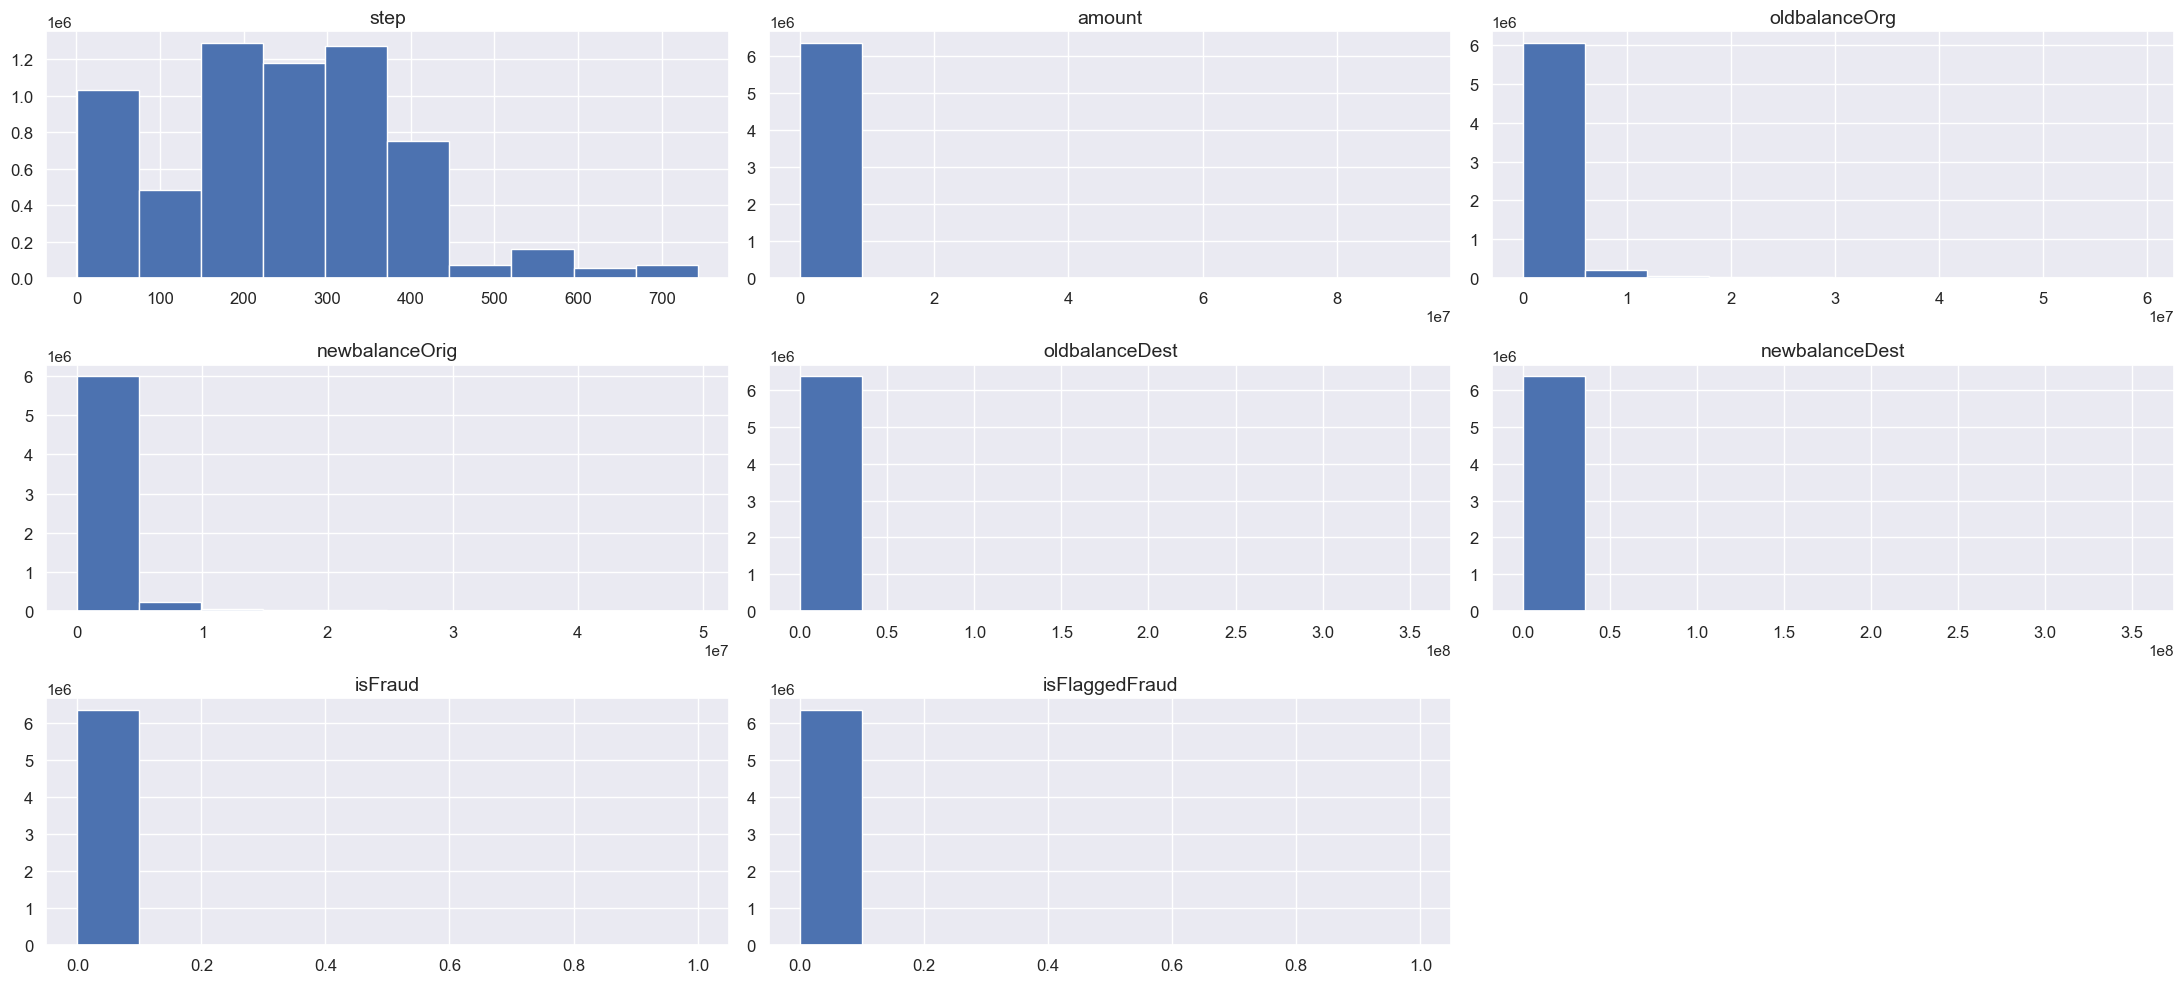

In [97]:
display_dataset_distributions(df)

## 2. Caracterización de variables

#### 2.1 Datos faltantes

In [10]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [11]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [12]:
df_modified = df.drop(['step', 'type', 'nameOrig', 'nameDest', 'isFraud'], axis=1)
df_modified.head(10)

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,9839.64,170136.00,160296.36,0.0,0.00,0
1,1864.28,21249.00,19384.72,0.0,0.00,0
2,181.00,181.00,0.00,0.0,0.00,0
3,181.00,181.00,0.00,21182.0,0.00,0
4,11668.14,41554.00,29885.86,0.0,0.00,0
5,7817.71,53860.00,46042.29,0.0,0.00,0
6,7107.77,183195.00,176087.23,0.0,0.00,0
7,7861.64,176087.23,168225.59,0.0,0.00,0
8,4024.36,2671.00,0.00,0.0,0.00,0
9,5337.77,41720.00,36382.23,41898.0,40348.79,0


Separación en train set y test set

In [13]:
train_ratio = 0.8
test_ratio = 0.2
use_cols = ['amount', 'oldbalanceOrg',	'newbalanceOrig','oldbalanceDest', 	'newbalanceDest']
X_train, X_test, y_train, y_test = train_test_split(
    #df[use_cols], 
    df_modified,
    df['isFraud'],  
    train_size=train_ratio,
    test_size=test_ratio,
    random_state=1)

X_train.shape, X_test.shape

((5090096, 6), (1272524, 6))

### Escalado de datos

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Training the model

In [114]:
lregression = LogisticRegression()

In [115]:
lregression.fit(X_train_scaled, y_train)

LogisticRegression()

In [116]:
### Model predict
y_pred = lregression.predict(X_test_scaled)

### Metrics

In [117]:
cnf_matrix =  metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1270797,      80],
       [    982,     665]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted')

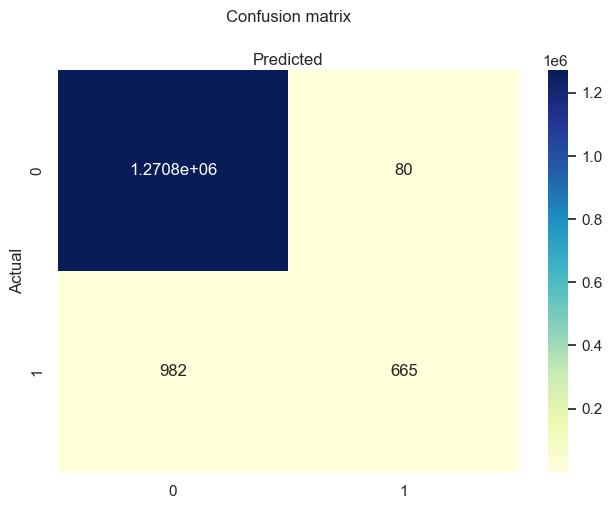

In [118]:
### Confusion matrix visualization with heatmap

class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

#Text(0.5, 257.44, 'Predicted')

### Evalauation metrics

In [119]:
target_names = ['No fraud', 'Fraud']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      1.00      1.00   1270877
       Fraud       0.89      0.40      0.56      1647

    accuracy                           1.00   1272524
   macro avg       0.95      0.70      0.78   1272524
weighted avg       1.00      1.00      1.00   1272524



## Balanceo de datos

### Random Over Sampling

In [34]:
ros_method = RandomOverSampler()
#Apply resampling to the training data only
X_resampled, y_resampled = ros_method.fit_resample(X_train_scaled, y_train)


##### Logistic regression for ROS

In [121]:
lregression_ros = LogisticRegression()
lregression_ros.fit(X_resampled, y_resampled)

LogisticRegression()

In [122]:
# Testing the model
target_names = ['No fraud', 'Fraud']
predicted_ros = lregression_ros.predict(X_test_scaled)
print(classification_report(y_test, predicted_ros, target_names=target_names))


              precision    recall  f1-score   support

    No fraud       1.00      0.97      0.98   1270877
       Fraud       0.04      0.89      0.07      1647

    accuracy                           0.97   1272524
   macro avg       0.52      0.93      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524



### Class weighting

In [15]:
class_weight = LogisticRegressionCV(class_weight='balanced')
class_weight.fit(X_train_scaled, y_train)

LogisticRegressionCV(class_weight='balanced')

In [25]:
target_names = ['No fraud', 'Fraud']
predicted_class_weight = class_weight.predict(X_test_scaled)
proba_class_weight = class_weight.predict_proba(X_test_scaled)
print(classification_report(y_test, predicted_class_weight, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      0.99      0.99   1270877
       Fraud       0.07      0.69      0.13      1647

    accuracy                           0.99   1272524
   macro avg       0.54      0.84      0.56   1272524
weighted avg       1.00      0.99      0.99   1272524



In [20]:
cfmatrix =   metrics.confusion_matrix(y_test, predicted_class_weight)
cfmatrix

array([[1256470,   14407],
       [    503,    1144]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted')

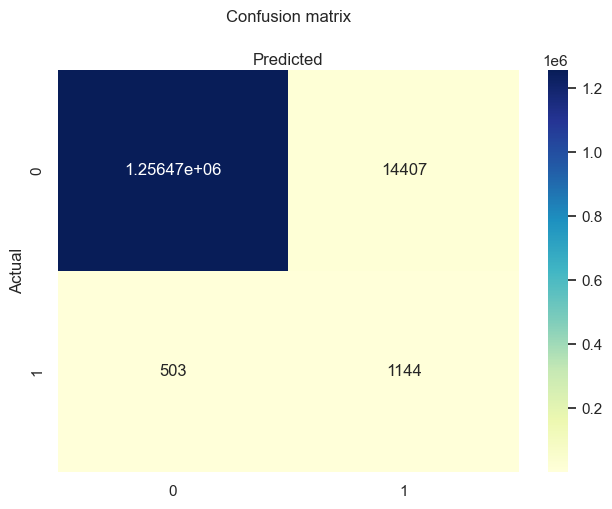

In [22]:
class_names = [0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cfmatrix), annot=True, cmap="YlGnBu", fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [34]:
precision, recall, threshold=precision_recall_curve(y_test, proba_class_weight[:,1])
print('Area bajo la curva ROC:', roc_auc_score(y_test, proba_class_weight[:,1]))
print('Area bajo la curva Precision-Recall:', auc(recall, precision))

Area bajo la curva ROC: 0.9666095524656316
Area bajo la curva Precision-Recall: 0.5047428974502982


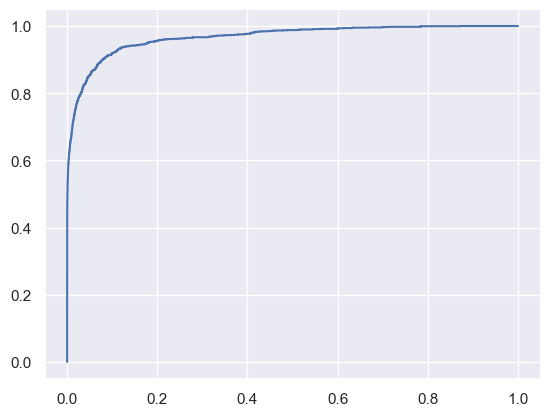

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test, proba_class_weight[:,1])
plt.plot(fpr, tpr)

### SMOTE

In [15]:
smote_method = SMOTE()
#Apply resampling to the training data only
X_resampled_smote, y_resampled_smote = smote_method.fit_resample(X_train_scaled, y_train)

##### Logistic regression for SMOTE

In [124]:
lregression_smote = LogisticRegression()
lregression_smote.fit(X_resampled_smote, y_resampled_smote)

LogisticRegression()

In [125]:
#Testing the model
target_names = ['No fraud', 'Fraud']
predicted_smote = lregression_smote.predict(X_test_scaled)
print(classification_report(y_test, predicted_smote, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      0.97      0.98   1270877
       Fraud       0.04      0.90      0.07      1647

    accuracy                           0.97   1272524
   macro avg       0.52      0.93      0.53   1272524
weighted avg       1.00      0.97      0.98   1272524



## Decision tree

In [126]:
target_names = ['No fraud', 'Fraud']
decisionTree = DecisionTreeClassifier()
decisionTree.fit(X_resampled, y_resampled)

DecisionTreeClassifier()

#### Metrics

In [127]:
target_names = ['No fraud', 'Fraud']
decisionTree_predict = decisionTree.predict(X_test_scaled)
print(classification_report(y_test, decisionTree_predict, target_names=target_names))

              precision    recall  f1-score   support

    No fraud       1.00      0.98      0.99   1270877
       Fraud       0.03      0.57      0.06      1647

    accuracy                           0.98   1272524
   macro avg       0.52      0.77      0.52   1272524
weighted avg       1.00      0.98      0.99   1272524



## Random Forest

In [128]:
rf = RandomForestClassifier()
rf.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [129]:
rf_predict = rf.predict(X_test_scaled)
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270877
           1       0.03      0.45      0.05      1647

    accuracy                           0.98   1272524
   macro avg       0.51      0.71      0.52   1272524
weighted avg       1.00      0.98      0.99   1272524



### RF with ROS 

In [17]:
rf_ros = RandomForestClassifier()
rf_ros.fit(X_resampled, y_resampled)

RandomForestClassifier()

In [35]:
rf_predict_ros = rf_ros.predict(X_test_scaled)
print(classification_report(y_test, rf_predict_ros))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270877
           1       0.18      0.35      0.23      1647

    accuracy                           1.00   1272524
   macro avg       0.59      0.67      0.62   1272524
weighted avg       1.00      1.00      1.00   1272524



### RF with resample smote

In [16]:
rf_smote = RandomForestClassifier()
rf_smote.fit(X_resampled_smote, y_resampled_smote)

RandomForestClassifier()

In [17]:
rf_predict_smote = rf_smote.predict(X_test_scaled)
print(classification_report(y_test, rf_predict_smote))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270877
           1       0.11      0.75      0.18      1647

    accuracy                           0.99   1272524
   macro avg       0.55      0.87      0.59   1272524
weighted avg       1.00      0.99      0.99   1272524

